## The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

### Compute the camera matrix and distortion coefficients

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

def cameraMatandCoe():

    # Number of corners in the x and y 
    nx = 9
    ny = 6

    objectPoints = [] # The 3D points in the real world
    imagePoints = [] # The 2D points in an image plane

    # Make a list of calibration images
    images = glob.glob('camera_cal/calibration*.jpg')

    # Preparing the object points
    objp = np.zeros((6*9,3), np.float32)

    # Prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
    i = 0
    imglist = []
    # go through each image in the list
    for fname in images:

        img = cv2.imread(fname)

        # Convert image to grayscale
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

        if ret == True:
            imagePoints.append(corners)
            objectPoints.append(objp)

            img = cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
            imglist.append(img)
        else:
            i += 1

    # Test the undistortion on an image
    img = cv2.imread('camera_cal\calibration1.jpg')


    # Calibrate the camera
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objectPoints, imagePoints, img.shape[0:2], None, None)

    # Find the destination image
    dst = cv2.undistort(img, mtx, dist, None, mtx)

#     # Visualize undistortion
#     f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
#     ax1.imshow(img)
#     ax1.set_title('Original Image', fontsize=30)
#     ax2.imshow(dst)
#     ax2.set_title('Undistorted Image', fontsize=30)
    return dst, mtx, dist
dst, mtx, dist = cameraMatandCoe()

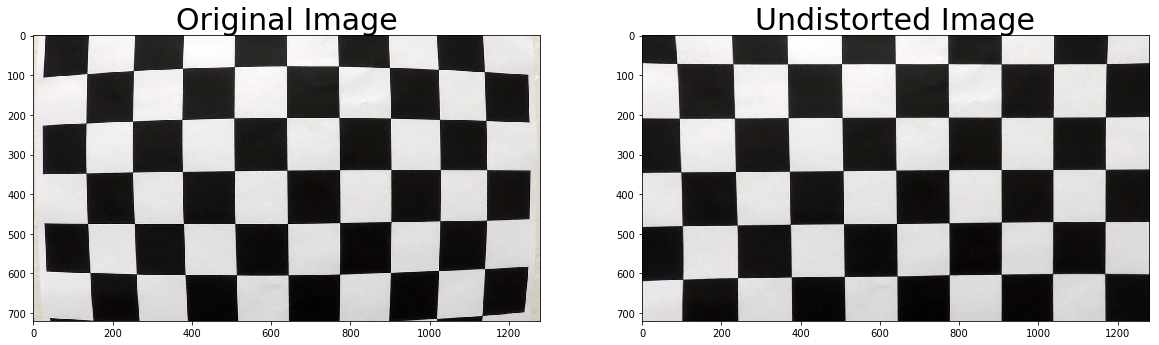

In [2]:
# # Here is the original raw image from the camera and the undistorted image
# image = cv2.imread('test_images/test5.jpg')
# img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# dst, mtx = cameraMatandCoe()
# unDst = cv2.undistort(img, mtx, dist, None, mtx)
# # Visualize undistortion
# f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
# ax1.imshow(img)
# ax1.set_title('Original Image', fontsize=30)
# ax2.imshow(unDst)
# ax2.set_title('Undistorted Image', fontsize=30)

def undistortImg(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     dst, mtx, dist = cameraMatandCoe()
    unDst = cv2.undistort(img, mtx, dist, None, mtx)
    return unDst
test = cv2.imread('camera_cal/calibration1.jpg')
testRgb = cv2.cvtColor(test, cv2.COLOR_BGR2RGB)
temp = undistortImg(test)
# Visualize result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(testRgb)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(temp)
ax2.set_title('Undistorted Image', fontsize=30)

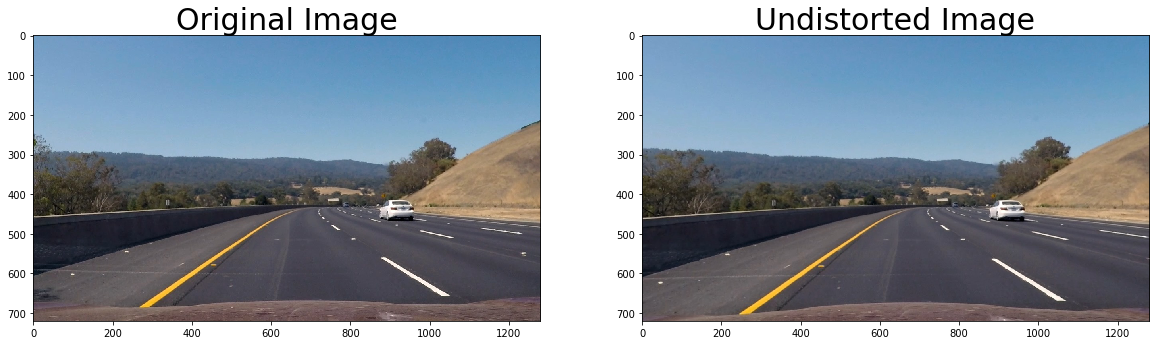

In [3]:
# Now show how the undistortion function works on a test image
testImg = cv2.imread('test_images/test3.jpg')
testImgRgb = cv2.cvtColor(testImg, cv2.COLOR_BGR2RGB)
result = undistortImg(testImg)
# Visualize result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(testImgRgb)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(result)
ax2.set_title('Undistorted Image', fontsize=30)

In [4]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

(720, 1280)


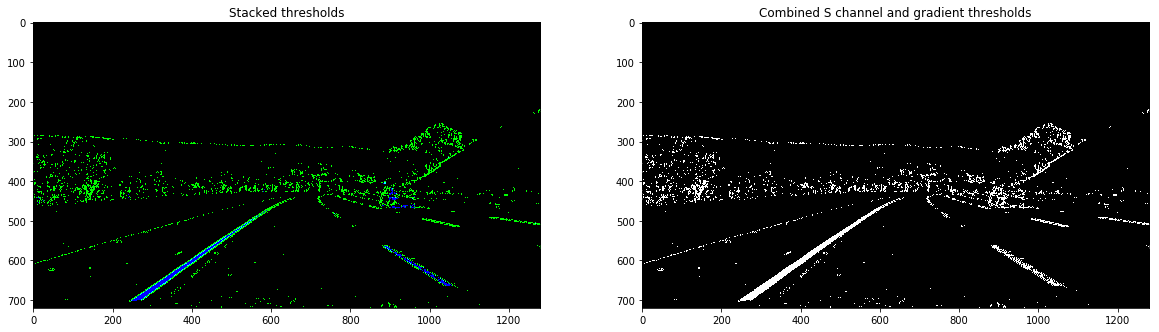

In [5]:

def cvtToBinary(unDst):
    # Convert to HLS color space and separate the S channel
    # Note: img is the undistorted image
    hls = cv2.cvtColor(unDst, cv2.COLOR_RGB2HLS).astype(np.float)
    s_channel = hls[:,:,2]

    # Grayscale image
    # NOTE: we already saw that standard grayscaling lost color information for the lane lines
    # Explore gradients in other colors spaces / color channels to see what might work better
    gray = cv2.cvtColor(unDst, cv2.COLOR_RGB2GRAY)

    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    thresh_min = 20
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Threshold color channel
    s_thresh_min = 170
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

    return combined_binary, color_binary
binary, colorBin = cvtToBinary(result)

#Visualize undistortion
# f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
# ax1.imshow(result)
# ax1.set_title('Original Image', fontsize=30)
# ax2.imshow(binary, cmap='gray')
# ax2.set_title('Binary Image', fontsize=30)
# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Stacked thresholds')
ax1.imshow(colorBin)

ax2.set_title('Combined S channel and gradient thresholds')
ax2.imshow(binary, cmap='gray')
print(binary.shape)

This is just an expirement to see if a tool can get us better grad/mag/dir thresholds for a binary image

In [6]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return sxbinary

def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Calculate the magnitude 
    mag = np.sqrt(sobelx**2 + sobely**2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*mag/np.max(mag))
    # 5) Create a binary mask where mag thresholds are met
    sxbinary = np.zeros_like(mag)
    # 6) Return this mask as your binary_output image
    sxbinary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    return sxbinary

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    arctan = np.arctan2(abs_sobely, abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    binaryMask = np.zeros_like(arctan)
    binaryMask[(arctan >= thresh[0]) & (arctan <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binaryMask

def hls_binary(image, thresh):
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS).astype(np.float)
    s_channel = hls[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= thresh[0]) & (s_channel <= thresh[1])] = 1
    return s_binary

def combined_binary_mask(image, ksize, mag_low, mag_high, dir_low, dir_high, hls_low, hls_high, bright_low, bright_high):

    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(bright_low, bright_high))
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(bright_low, bright_high))
    mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(mag_low, mag_high))
    dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(dir_low, dir_high))
    s_binary = hls_binary(image, thresh=(hls_low,hls_high))

    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1)) | (s_binary == 1)] = 1
    return combined

<function __main__.interactive_mask>

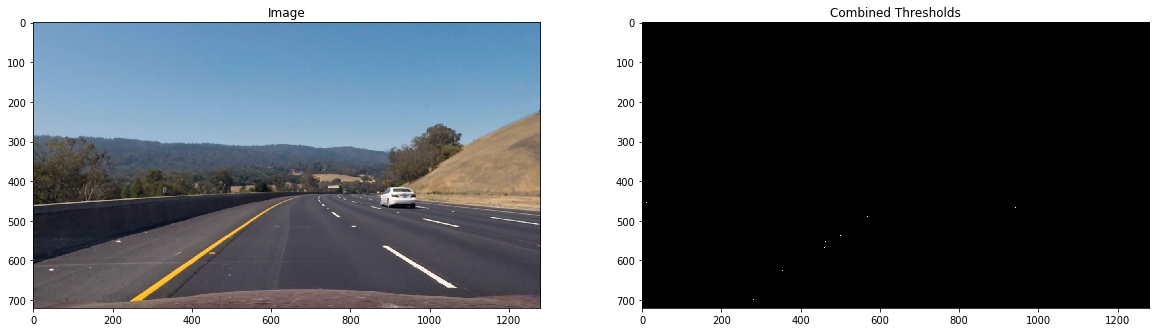

In [7]:
from IPython.html import widgets
from IPython.html.widgets import interact
from IPython.display import display
import matplotlib.image as mpimg

image = mpimg.imread('test_images/test3.jpg')
image = cv2.undistort(image, mtx, dist, None, mtx)

def interactive_mask(ksize, mag_low, mag_high, dir_low, dir_high, hls_low, hls_high, bright_low, bright_high):
    combined = combined_binary_mask(image, ksize, mag_low, mag_high, dir_low, dir_high,\
                                    hls_low, hls_high, bright_low, bright_high)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.set_title('Image')
    ax1.imshow(image)

    ax2.set_title('Combined Thresholds')
    ax2.imshow(combined, cmap='gray')

interact(interactive_mask, ksize=(1,31,2), mag_low=(0,255), mag_high=(0,255),\
         dir_low=(0, np.pi/2), dir_high=(0, np.pi/2), hls_low=(0,255),\
         hls_high=(0,255), bright_low=(0,255), bright_high=(0,255))

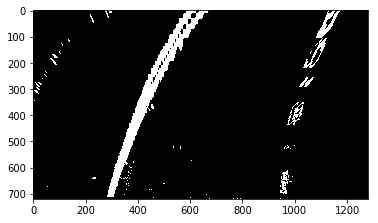

In [8]:
# Apply perspective transform





#Combination of both hough lines and normal image
#comboImage =  weighted_img(houghTransform, initial_image, α=0.8, β=1., λ=0.)
def perspectiveTrans(img, binary):
    
    # Define the source and destination points
    src = np.float32(
    [[270, 720], # Bottom Left
    [1150, 720], # Bottom Right
    [585, 450],  # Top Left
    [690, 450]]) # Rop Right
    dst = np.float32(
    [[320, 720],
    [960, 720],
    [320, 0],
    [960, 0]])

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_size = (gray.shape[1], gray.shape[0])
    # Calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Calculate the inverse perspective transform
    Minv = cv2.getPerspectiveTransform(dst, src)
    # Warp an image
    warped = cv2.warpPerspective(binary, M, img_size)
    
    return Minv, warped
parm2, parm3 = perspectiveTrans(testImgRgb,binary)
plt.imshow(parm3, cmap='gray')
# Draw the lines for the points of interest (source)
# # Left line
# cv2.line(draws, (src[0][0], src[0][1]), (src[2][0], src[2][1]), (255,0,0), thickness = 5)
# # Right Line
# cv2.line(draws, (src[1][0], src[1][1]), (src[3][0], src[3][1]), (255,0,0), thickness = 5)
# # Bottom Line
# cv2.line(draws, (src[0][0], src[0][1]), (src[1][0], src[1][1]), (255,0,0), thickness = 5)
# # Top Line
# cv2.line(draws, (src[2][0], src[2][1]), (src[3][0], src[3][1]), (255,0,0), thickness = 5)

# # Draw the lines for the destiation 
# # Left Line
# cv2.line(draws, (dst[0][0], dst[0][1]), (dst[2][0], dst[2][1]), (255,0,0), thickness = 5)
# # Right Line
# cv2.line(draws, (dst[1][0], dst[1][1]), (dst[3][0], dst[3][1]), (255,0,0), thickness = 5)
# # Bottom Line
# cv2.line(draws, (dst[0][0], dst[0][1]), (dst[1][0], dst[1][1]), (255,0,0), thickness = 5)
# # Top Line
# cv2.line(draws, (dst[2][0], dst[2][1]), (dst[3][0], dst[3][1]), (255,0,0), thickness = 5)


# # Visualize undistortion
# f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
# ax1.imshow(binary, cmap = 'gray')
# ax1.set_title('Original Image', fontsize=30)
# ax2.imshow(warpedImg, cmap = 'gray')
# ax2.set_title('Warped Image', fontsize=30)

In [9]:
# image = cv2.imread('test_images/test1.jpg')
# undImg = undistortImg(image)
# draws = undImg

# src = np.float32(
#     [[270, 720], # Bottom Left
#     [1150, 720], # Bottom Right
#     [585, 450],  # Top Left
#     [690, 450]]) # Rop Right
# dst = np.float32(
#     [[320, 720],
#     [960, 720],
#     [320, 0],
#     [960, 0]])

# #Draw the lines for the points of interest (source)
# # Left line
# cv2.line(draws, (src[0][0], src[0][1]), (src[2][0], src[2][1]), (255,0,0), thickness = 5)
# # Right Line
# cv2.line(draws, (src[1][0], src[1][1]), (src[3][0], src[3][1]), (255,0,0), thickness = 5)
# # Bottom Line
# cv2.line(draws, (src[0][0], src[0][1]), (src[1][0], src[1][1]), (255,0,0), thickness = 5)
# # Top Line
# cv2.line(draws, (src[2][0], src[2][1]), (src[3][0], src[3][1]), (255,0,0), thickness = 5)

# # Draw the lines for the destiation 
# # Left Line
# cv2.line(draws, (dst[0][0], dst[0][1]), (dst[2][0], dst[2][1]), (255,0,0), thickness = 5)
# # Right Line
# cv2.line(draws, (dst[1][0], dst[1][1]), (dst[3][0], dst[3][1]), (255,0,0), thickness = 5)
# # Bottom Line
# cv2.line(draws, (dst[0][0], dst[0][1]), (dst[1][0], dst[1][1]), (255,0,0), thickness = 5)
# # Top Line
# cv2.line(draws, (dst[2][0], dst[2][1]), (dst[3][0], dst[3][1]), (255,0,0), thickness = 5)
# plt.imshow(draws)

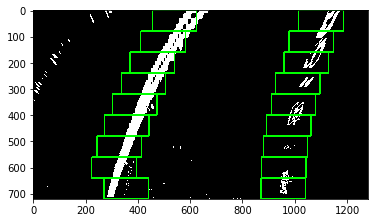

In [10]:
# Find the lane lines using a histogram
# Create two test lane objects to hold info about the lanes
testLeftLane = Line()
testRightLane = Line()
def findLaneLines(warpedImg):
    # Create a historgram of the bottom half of the warped binary image
    indicies = np.int(warpedImg.shape[0]/2)
    histogram = np.sum(warpedImg[indicies:,:], axis=0)
    # Create an image to draw on
    outputImg = np.dstack((warpedImg, warpedImg, warpedImg))*255

    #Save initial points where the peaks are for the left and right half of the histogram
    midpoint = np.int(histogram.shape[0]/2)
    leftxBase = np.argmax(histogram[:midpoint])
    rightxBase = np.argmax(histogram[midpoint:]) + midpoint
    
    # Set how many windows to fill vertically the whole frame
    numOfWindows = 9

    # Set the window height
    windowHeight = np.int(warpedImg.shape[0]/numOfWindows)

    # Store all the none 0 pixels of each axis
    notZero = warpedImg.nonzero()
    notZeroy = np.array(notZero[0])
    notZerox = np.array(notZero[1])

    # Keep track of the current positions
    leftxCurrent = leftxBase
    rightxCurrent = rightxBase

    #120
    margin = 85
    #10
    minpix = 80

    leftLaneInds = []
    rightLaneInds = []

    # Step through every window
    for window in range(numOfWindows):
        # Find window boundaries
        winyLow = warpedImg.shape[0] - (window + 1)*windowHeight
        winyHigh = warpedImg.shape[0] - window*windowHeight
        winxLeftLow = leftxCurrent - margin
        winxLeftHigh = leftxCurrent + margin
        winxRightLow = rightxCurrent - margin
        winxRightHigh = rightxCurrent + margin

        # Draw the windows
        cv2.rectangle(outputImg,(winxLeftLow,winyLow),(winxLeftHigh,winyHigh), (0,255,0), 3)
        cv2.rectangle(outputImg,(winxRightLow,winyLow),(winxRightHigh,winyHigh), (0,255,0), 3)

        # Find and store the hot pixels     
        leftInd = ((notZeroy >= winyLow) & (notZeroy < winyHigh) & (notZerox >= winxLeftLow) & (notZerox < winxLeftHigh)).nonzero()[0]
        rightInd = ((notZeroy >= winyLow) & (notZeroy < winyHigh) & (notZerox >= winxRightLow) & (notZerox < winxRightHigh)).nonzero()[0]
        # Append these indices to the lists
        leftLaneInds.append(leftInd)
        rightLaneInds.append(rightInd)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(leftInd) > minpix:
            leftxCurrent = np.int(np.mean(notZerox[leftInd]))
        if len(rightInd) > minpix:
            rightxCurrent = np.int(np.mean(notZerox[rightInd]))

    # Concatenate the arrays of the indicies
    leftLaneInds = np.concatenate(leftLaneInds)
    rightLaneInds = np.concatenate(rightLaneInds)
    
    # Extract left and right line pixels
    leftx = notZerox[leftLaneInds]
    lefty = notZeroy[leftLaneInds]
    rightx = notZerox[rightLaneInds]
    righty = notZeroy[rightLaneInds]

    # Fit a line to each
    leftFit = np.polyfit(lefty, leftx, 2)

    rightFit = np.polyfit(righty, rightx, 2)
    
     # Generate x and y values for plotting
    ploty = np.linspace(0,warpedImg.shape[0]-1, warpedImg.shape[0])
    leftFitx = leftFit[0]*ploty**2 + leftFit[1]*ploty + leftFit[2]
    rightFitx = rightFit[0]*ploty**2 + rightFit[1]*ploty + rightFit[2]
    testLeftLane.detected = True
    testRightLane.detected = True
    
    return leftLaneInds, rightLaneInds, leftx, lefty, rightx, righty, leftFit, rightFit, outputImg, notZerox, notZeroy, ploty, leftFitx, rightFitx
leftLaneInds, rightLaneInds, leftx, lefty, rightx, righty, leftFit, rightFit, outputImg, notZerox, notZeroy, ploty, leftFitx, rightFitx = findLaneLines(parm3)   
plt.imshow(outputImg)

In [11]:
## visualize the lines
def viewLaneLines(leftLaneInds, rightLaneInds, leftFit, rightFit, warpedImg, outputImg, notZerox, notZeroy):
    ploty = np.linspace(0, warpedImg.shape[0]-1, warpedImg.shape[0] )
    leftFitx = leftFit[0]*ploty**2 + leftFit[1]*ploty + leftFit[2]
    rightFitx = rightFit[0]*ploty**2 + rightFit[1]*ploty + rightFit[2]

    outputImg[notZeroy[leftLaneInds], notZerox[leftLaneInds]] = [255, 0, 0]
    outputImg[notZeroy[rightLaneInds], notZerox[rightLaneInds]] = [0, 0, 255]
#     plt.imshow(outputImg)
#     plt.plot(leftFitx, ploty, color='yellow')
#     plt.plot(rightFitx, ploty, color='yellow')
#     plt.xlim(0, 1280)
#     plt.ylim(720, 0)
    return outputImg
outputImg = viewLaneLines(leftLaneInds, rightLaneInds, leftFit, rightFit, parm3, outputImg, notZerox, notZeroy)    

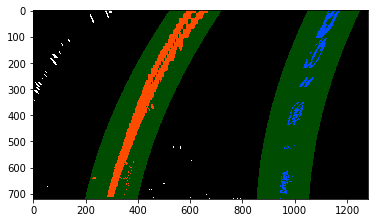

In [12]:
# If you already found a lane line before than use this to find the next
def findLaneLinesafterFindingThem(warpedImg, leftFit, rightFit):

    notZero = warpedImg.nonzero()
    notZeroy = np.array(notZero[0])
    notZerox = np.array(notZero[1])

    margin = 100

    leftLaneInds = ((notZerox > (leftFit[0]*(notZeroy**2) + leftFit[1]*notZeroy + leftFit[2] - margin)) & (notZerox < (leftFit[0]*(notZeroy**2) + leftFit[1]*notZeroy + leftFit[2] + margin)))
    rightLaneInds = ((notZerox > (rightFit[0]*(notZeroy**2) + rightFit[1]*notZeroy + rightFit[2] - margin)) & (notZerox < (rightFit[0]*(notZeroy**2) + rightFit[1]*notZeroy + rightFit[2] + margin)))

    # Get left and right lane line pixel positions
    leftx = notZerox[leftLaneInds]
    lefty = notZeroy[leftLaneInds]
    rightx = notZerox[rightLaneInds]
    righty = notZeroy[rightLaneInds]

    # Fit the line
    leftFit = np.polyfit(lefty, leftx, 2)
    rightFit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0,warpedImg.shape[0]-1, warpedImg.shape[0])
    leftFitx = leftFit[0]*ploty**2 + leftFit[1]*ploty + leftFit[2]
    rightFitx = rightFit[0]*ploty**2 + rightFit[1]*ploty + rightFit[2]


    ## Now visualize the rults
    outImg = np.dstack((warpedImg, warpedImg, warpedImg))*255
    windowImg = np.zeros_like(outImg)

    # Color in left and right line
    outImg[notZeroy[leftLaneInds], notZerox[leftLaneInds]] = [255,0,0]
    outImg[notZeroy[rightLaneInds], notZerox[rightLaneInds]] = [0,0,255]

    # Generate a polygon to illustrate the search window area and recast the x and y points into usable format for cv2.fillPoly()
    leftLinWindow1 = np.array([np.transpose(np.vstack([leftFitx-margin, ploty]))])
    leftLinWindow2 = np.array([np.flipud(np.transpose(np.vstack([leftFitx+margin, ploty])))])
    leftLinePts = np.hstack((leftLinWindow1, leftLinWindow2))
    rightLineWindow1 = np.array([np.transpose(np.vstack([rightFitx-margin, ploty]))])
    rightLineWindow2 = np.array([np.flipud(np.transpose(np.vstack([rightFitx+margin, ploty])))])
    rightLinePts = np.hstack((rightLineWindow1, rightLineWindow2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(windowImg, np.int_([leftLinePts]), (0,255, 0))
    cv2.fillPoly(windowImg, np.int_([rightLinePts]), (0,255, 0))
    result = cv2.addWeighted(outImg, 1, windowImg, 0.3, 0)
    return leftFitx, rightFitx, ploty, leftLaneInds, rightLaneInds, notZerox, notZeroy, result, leftFit, rightFit
leftFitx, rightFitx, ploty, leftLaneInds, rightLaneInds, notZerox, notZeroy, result, leftFit, rightFit = findLaneLinesafterFindingThem(parm3, leftFit, rightFit)
plt.imshow(result)

In [13]:
# This function will validate the lines that were found and throw out bad lines
def validate(leftFitx, rightFitx, ploty, leftLaneInds, rightLaneInds, notZerox, notZeroy, outputImg, leftFit, rightFit):
#     The following validation criteria can be used to remove incorrect lines:
    
#   1. lane width is in defined borders
    maxLaneWidth = 700
#   2. lane lines have the same concavity
#   3. the second degree parameter of both fits are not too different (ratio of parameters is less than some value)
#   4. ratio of lines curvature is not too big (be careful here with straight lane)
#   5. distance between left and right lines at the base of the image is roughly the same as at the top of the image (in birds-eye view)
#   6. lane curvature, distance from the center, polynomial coefficients and so on.. don't differ a lot from the same values from the previous frame
    return valid

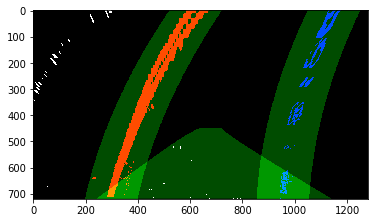

In [14]:
# We will warp the image back to image space and place highlight the lane
def highlightLane(warpedImg, leftFitx, rightFitx, ploty, invCamMat, unDst):

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warpedImg).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([leftFitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([rightFitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, invCamMat, (unDst.shape[1], unDst.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(unDst, 1, newwarp, 0.3, 0)
    return result
highlightedImg = highlightLane(parm3, leftFitx, rightFitx, ploty, parm2, result)
plt.imshow(highlightedImg)

In [15]:
# Define conversions in x and y from pixels space to meters
def curvatureReadings(highlightedImg, ploty, leftFitx, rightFitx):

    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    yEval = 719
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftFitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightFitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*yEval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*yEval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    
    # The position towards the center is calculated below:
    # Position of car
    actualCarPos = (testImgRgb.shape[1]/2)
    # Position for center of lane = (xcordinateleftlane + xcordinaterightlane)/2
    centerOfLane = (leftFitx[yEval] + rightFitx[yEval])/2
    # Distance from center:
    distFromCenter = actualCarPos - centerOfLane
    distFromCenter *= xm_per_pix
    #Draw the text on the image
    font = cv2.FONT_HERSHEY_SIMPLEX
    st1 = str(left_curverad)
    st2 = str(right_curverad)
    st3 = str(distFromCenter)
    cv2.putText(highlightedImg, 'Left curvature radius: ' + st1 + '(m)',(10,100), font, 1,(255,255,255),2,cv2.LINE_AA)
    cv2.putText(highlightedImg, 'Right curvature radius: ' + st2 + '(m)',(10,130), font, 1,(255,255,255),2,cv2.LINE_AA)
    cv2.putText(highlightedImg, 'Distance from center: ' + st3,(10,160), font, 1,(255,255,255),2,cv2.LINE_AA)
    return highlightedImg

In [16]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# Create the two lane objectcs
leftLane = Line()
rightLane = Line()

In [17]:
found = False
def process_image(image):
    # Undistor the image
    undImg = undistortImg(image)
    # Threshold and create a binary image
#     binaryImg, img_stack = cvtToBinary(undImg)
    binaryImg = combined_binary_mask(image, 3, 80, 255, 0.00, 1.20,\
                                    100, 255, 75, 255)
#     plt.imshow(binaryImg)
    # Here we apply the prespective transform in order to find lane lines
    Minv, warpedImg = perspectiveTrans(undImg, binaryImg)
    # Now we will search and find the lane lines using a histogram approach
    #if the lane lines were not detected yet or failed validation criteria serval times use the sliding window method
    global leftFit
    global rightFit
    global found
    global leftLaneInds
    global rightLaneInds
    global outputImg
    global notZerox
    global notZeroy
#     if leftLane.detected == True or rightLane.detected == False:
    if found == True:
        leftFitx, rightFitx, ploty, leftLaneInds, rightLaneInds, notZerox, notZeroy, outputImg, leftFit, rightFit = findLaneLinesafterFindingThem(warpedImg, leftFit, rightFit)
        
    else:
        leftLaneInds, rightLaneInds, leftx, lefty, rightx, righty, leftFit, rightFit, outputImg, notZerox, notZeroy, ploty, leftFitx, rightFitx = findLaneLines(warpedImg)
        found = True
#     check validation
#     leftLaneInds, rightLaneInds, leftx, lefty, rightx, righty, leftFit, rightFit, outputImg, notZerox, notZeroy, ploty, leftFitx, rightFitx = findLaneLines(warpedImg)
    lanes = viewLaneLines(leftLaneInds, rightLaneInds, leftFit, rightFit, warpedImg, outputImg, notZerox, notZeroy)
    # Now we will highlight the lane
    highlightedLane = highlightLane(warpedImg, leftFitx, rightFitx, ploty, Minv, undImg)
    # Finally we will find the curvature
    result = curvatureReadings(highlightedLane, ploty, leftFitx, rightFitx)
    # return the BGR color image
    final = cv2.cvtColor(result, cv2.COLOR_RGB2BGR)
#     output = final
# #     output1 = cv2.resize(img_stack,(640, 360), interpolation = cv2.INTER_AREA)
#     output2 = cv2.resize(lanes,(640, 360), interpolation = cv2.INTER_AREA)
#     output1 = cv2.resize(warpedImg,(640, 360), interpolation = cv2.INTER_AREA)
#     # Create an array big enough to hold both images next to each other.
#     vis = np.zeros((720, 1280+640, 3))
#     # Copy both images into the composed image.
#     vis[:720, :1280,:] = output
#     vis[:360, 1280:1920,:] = output1
#     vis[360:720, 1280:1920,:] = output2
    return final

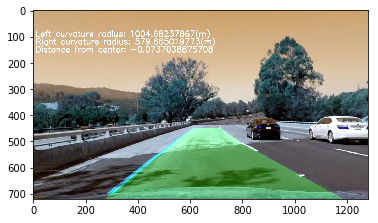

In [18]:
# test process_image function
image = cv2.imread('test_images/test4.jpg')
result = process_image(image)
plt.imshow(result)

In [19]:
# viewLaneLines(leftLaneInds, rightLaneInds, leftFit, rightFit, warpedImg, outputImg, notZerox, notZeroy)
# plt.imshow(warp, cmap='gray')
# plt.imshow(test)
# viewLaneLines(leftLaneInds, rightLaneInds, leftFit, rightFit, warpedImg, outputImg, notZerox, notZeroy)

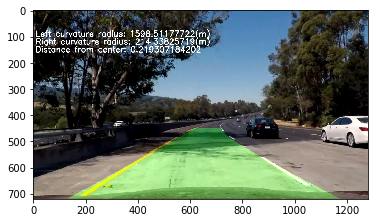

In [20]:
video = 'result_video.mp4'
clip1 = VideoFileClip("project_video.mp4")
test = clip1.get_frame(41.3)
result = process_image(test)
plt.imshow(result)

In [21]:
# step through each image
# .subclip(0,17)
video = 'result_video.mp4'
clip1 = VideoFileClip("project_video.mp4")
project_clip = clip1.fl_image(process_image)
%time project_clip.write_videofile(video, audio=False)

[MoviePy] >>>> Building video result_video.mp4
[MoviePy] Writing video result_video.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [08:01<00:00,  2.64it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: result_video.mp4 

Wall time: 8min 3s


In [22]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video))